In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import cv2

2024-01-29 13:41:31.047048: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-29 13:41:31.067053: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 13:41:31.067093: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 13:41:31.067641: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-29 13:41:31.071154: I tensorflow/core/platform/cpu_feature_guar

In [2]:
ds_train, ds_info = tfds.load(
    'eurosat/rgb', 
    shuffle_files=False,
    #as_supervised=True,  # Returns a tuple (img, label) instead of a dictionary {'image': img, 'label': label}
    with_info=True
)

2024-01-29 13:41:32.241193: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-29 13:41:32.255262: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-29 13:41:32.255385: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
ds_train = ds_train['train']

In [4]:
ds_train = ds_train.shuffle(1000, seed = 42)

2024-01-29 13:41:32.952305: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [5]:
train_dataset = ds_train.take(20000)
test_dataset = ds_train.skip(20000)

In [139]:
def generator(dataset):
    while True:  # Start an infinite loop
        for batch in dataset:
            images = batch["image"]
            images_np = images.numpy() 

            masks = np.zeros((batch_size, 64, 64))
            for i in range(batch_size):
                for j in range(8):
                    start_point = (np.random.randint(0, 64 - 1), 0)
                    end_point = (np.random.randint(0, 64 - 1), 63)
                    thickness = np.random.randint(2, 5) 
                    masks[i] = cv2.line(masks[i], start_point, end_point, (1), thickness)

            images_np = images_np / 255.0
            masks = np.stack(((masks),) * 3, axis=-1)

            yield (images_np * masks, images_np)

# Batch the datasets
batch_size = 8
train_dataset_batched = train_dataset.batch(batch_size)
test_dataset_batched = test_dataset.batch(batch_size)

# Create generators for the batched datasets
train_generator = generator(train_dataset_batched)
test_generator = generator(test_dataset_batched)

2024-01-29 14:18:19.626910: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [100]:
a, b = next(train_generator)

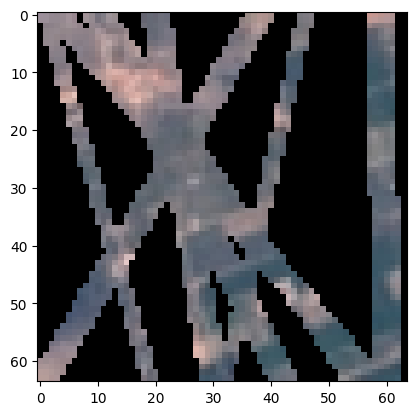

In [101]:
plt.imshow(a[0])

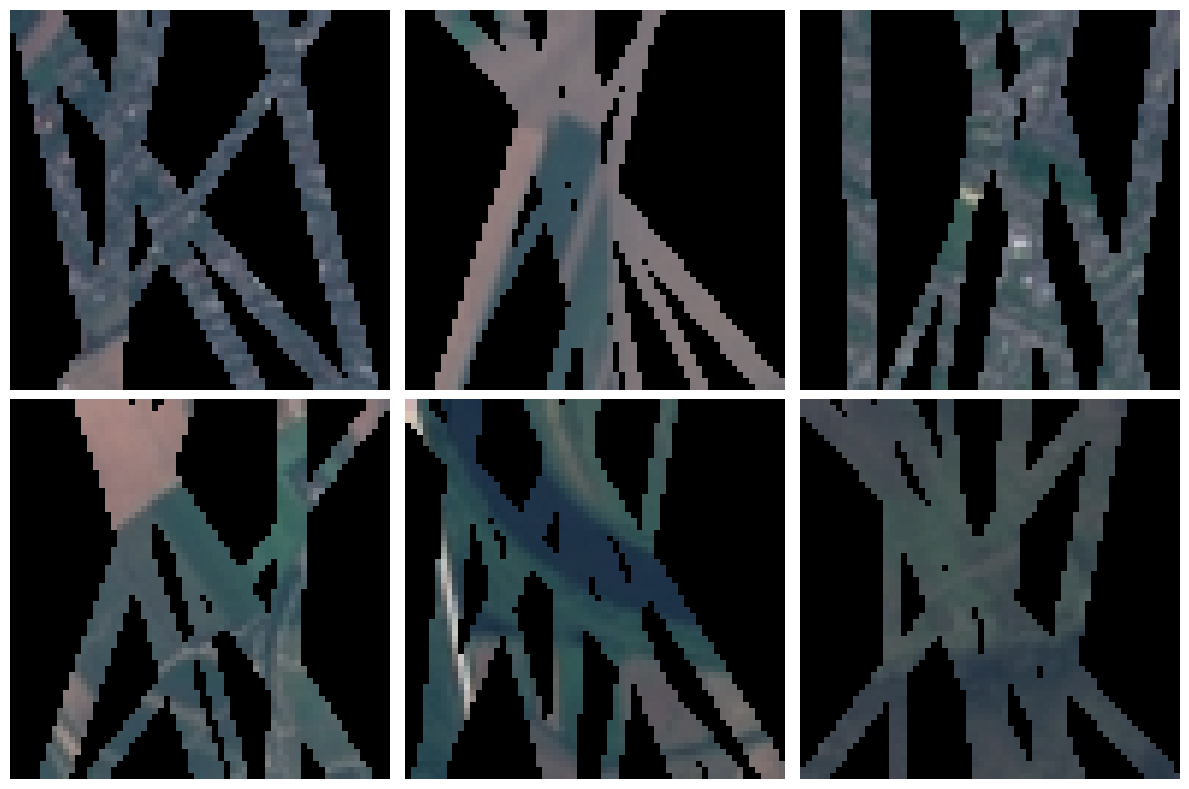

In [102]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))  # Adjust figsize as needed

for i, ax in enumerate(axes.flatten()):
    a,b = next(train_generator)
    
    # Plot image on each subplot
    ax.imshow(a[0])  # Use cmap='gray' if your images are grayscale
    ax.axis('off')  # Turn off axis

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

In [160]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def build_small_unet(input_size=(64, 64, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(conv3)
    merge1 = concatenate([conv2, up1], axis=3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge1)

    up2 = UpSampling2D(size=(2, 2))(conv4)
    merge2 = concatenate([conv1, up2], axis=3)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge2)

    # Output layer
    output = Conv2D(3, (1, 1), activation='sigmoid')(conv5)

    model = Model(inputs=inputs, outputs=output)

    return model

In [163]:
inpainting_model = build_small_unet()

In [164]:
inpainting_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_33 (Conv2D)          (None, 64, 64, 32)           896       ['input_13[0][0]']            
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)           0         ['conv2d_33[0][0]']           
 D)                                                                                               
                                                                                                  
 conv2d_34 (Conv2D)          (None, 32, 32, 64)           18496     ['max_pooling2d[0][0]'] 

In [165]:
inpainting_model.compile(optimizer='adam', loss='mean_squared_error')

In [166]:
# Fit the model
history = inpainting_model.fit(
    x=train_generator,  # Your training data generator
    epochs=20,  # Number of epochs to train for
    steps_per_epoch = 500
    #validation_data=validation_generator,  # Your validation data generator
    #steps_per_epoch=50,  # Number of steps per epoch, typically the number of batches in your training dataset
    #validation_steps=50  # Number of validation steps, typically the number of batches in your validation dataset
)

Epoch 1/20
500/500 [==============================] - 5s 5ms/step - loss: 0.0084
Epoch 2/20
500/500 [==============================] - 3s 6ms/step - loss: 0.0042
Epoch 3/20
500/500 [==============================] - 3s 6ms/step - loss: 0.0040
Epoch 4/20
500/500 [==============================] - 2s 4ms/step - loss: 0.0037
Epoch 5/20
500/500 [==============================] - 3s 5ms/step - loss: 0.0036
Epoch 6/20
 17/500 [>.............................] - ETA: 1s - loss: 0.0035

2024-01-29 14:29:42.464878: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


500/500 [==============================] - 3s 5ms/step - loss: 0.0036
Epoch 7/20
500/500 [==============================] - 2s 4ms/step - loss: 0.0035
Epoch 8/20
500/500 [==============================] - 3s 6ms/step - loss: 0.0034
Epoch 9/20
500/500 [==============================] - 3s 5ms/step - loss: 0.0035
Epoch 10/20
500/500 [==============================] - 2s 5ms/step - loss: 0.0035
Epoch 11/20
 11/500 [..............................] - ETA: 2s - loss: 0.0031

2024-01-29 14:29:55.122452: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


500/500 [==============================] - 3s 6ms/step - loss: 0.0035
Epoch 12/20
500/500 [==============================] - 3s 5ms/step - loss: 0.0033
Epoch 13/20
500/500 [==============================] - 3s 5ms/step - loss: 0.0033
Epoch 14/20
500/500 [==============================] - 2s 4ms/step - loss: 0.0033
Epoch 15/20
500/500 [==============================] - 2s 4ms/step - loss: 0.0034
Epoch 16/20
 10/500 [..............................] - ETA: 2s - loss: 0.0033

2024-01-29 14:30:07.725287: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


500/500 [==============================] - 3s 5ms/step - loss: 0.0034
Epoch 17/20
500/500 [==============================] - 2s 4ms/step - loss: 0.0032
Epoch 18/20
500/500 [==============================] - 2s 5ms/step - loss: 0.0033
Epoch 19/20
500/500 [==============================] - 3s 5ms/step - loss: 0.0032
Epoch 20/20
500/500 [==============================] - 3s 5ms/step - loss: 0.0033


2024-01-29 14:30:19.984818: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [167]:
samp = next(test_generator)

In [168]:
res = inpainting_model.predict(samp[0])

1/1 [==============================] - 0s 49ms/step


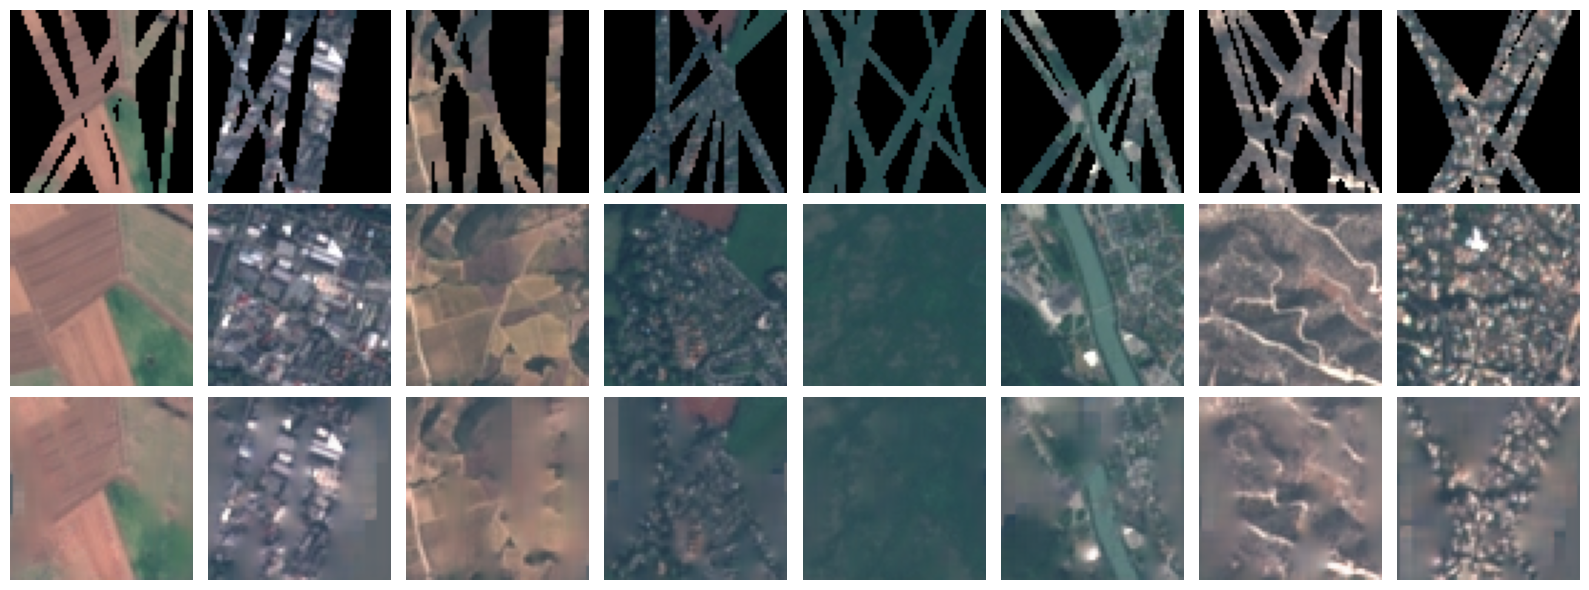

In [169]:
cols = 8
rows = 3

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 2, rows * 2))

for i in range(rows):
    for j in range(cols):
        ax = axes[i, j]
        
        # Select the appropriate array
        if i == 0:
            image = samp[0][j]
        elif i == 1:
            image = samp[1][j]
        else:
            image = res[j]

        ax.imshow(image, cmap='gray')  # Use cmap='gray' for grayscale images
        ax.axis('off')

plt.tight_layout()
plt.show()